In [ ]:
# 한글 폰트 설치하기 (꼭! 설치가 완료되면 [런타임 다시 시작]을 누르고 다시 실행하기)
!apt install fonts-nanum -y

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (52.7 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/dataset/vh_cls.zip'


zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/sample_data/vehicle')
zip_ref.close()

In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

#전이학습(Transfer Learning)을 이용한 분류작업

In [ ]:
from imutils import paths

search_dir = "/content/sample_data/vehicle"

image_paths = sorted(
    list(paths.list_images(search_dir))
)
print(">>> image count =", len(image_paths))

>>> image count = 323675


In [ ]:
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(image_paths)
df.head(5)

,Filepath,Label
0,/content/sample_data/vehicle/vh1/╝╝┤▄_K7-242.jpg,vh1
1,/content/sample_data/vehicle/vh1/╝╝┤▄_╜ε│¬┼╕-3...,vh1
2,/content/sample_data/vehicle/vh1/╝╝┤▄_SM5-5894...,vh1
3,/content/sample_data/vehicle/vh1/╝╝┤▄_╜ε│¬┼╕-1...,vh1
4,/content/sample_data/vehicle/vh1/╝╝┤▄_▒╫╖ú└·-1...,vh1


In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 323675

Number of different labels: 5

Labels: ['vh1' 'vh3' 'vh2' 'vh5' 'vh4']


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


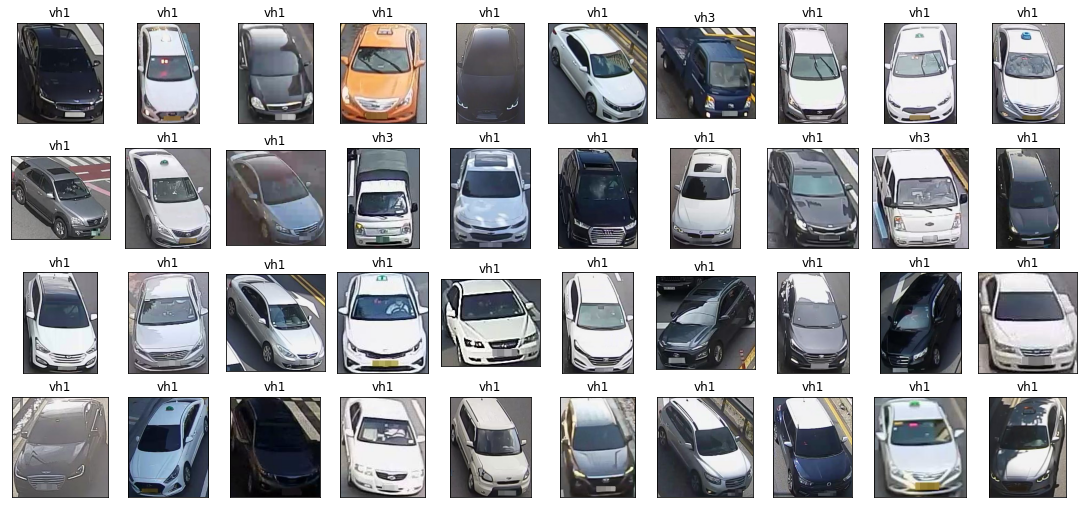

In [ ]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((291307, 2), (32368, 2))

In [ ]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory(search_dir,
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory(search_dir,
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 258941 images belonging to 5 classes.
Found 64734 images belonging to 5 classes.


In [ ]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
    # 라벨 개수가 3개이기 때문에 Dencs도 3로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Found 262177 validated image filenames belonging to 5 classes.
Found 29130 validated image filenames belonging to 5 classes.
Found 32368 validated image filenames belonging to 5 classes.




### 좋은 효율을 내는 모델 성능확인 1 (DenseNet201)

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 98980 validated image filenames belonging to 3 classes.
Found 10997 validated image filenames belonging to 3 classes.
Found 12220 validated image filenames belonging to 3 classes.
74850304/74836368 [==============================] - 0s 0us/step
Epoch 1/7
3094/3094 [==============================] - 447s 138ms/step - loss: 0.0139 - accuracy: 0.9949 - val_loss: 0.0054 - val_accuracy: 0.9984
Epoch 2/7
3094/3094 [==============================] - 348s 112ms/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.0042 - val_accuracy: 0.9985
Epoch 3/7
3094/3094 [==============================] - 349s 113ms/step - loss: 0.0042 - accuracy: 0.9985 - val_loss: 0.0058 - val_accuracy: 0.9984
Epoch 4/7
3094/3094 [==============================] - 343s 111ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.0065 - val_accuracy: 0.9983
Epoch 5/7
3094/3094 [==============================] - 345s 111ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.0074 - val_accuracy: 0.9979
Epoch 6/7
3094

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


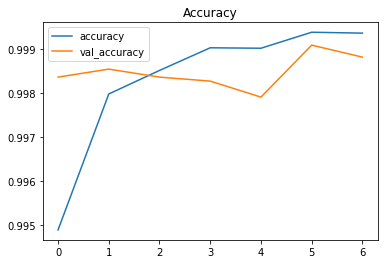

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

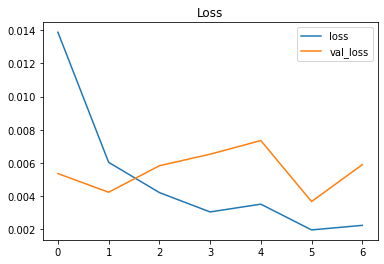

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 99.91%


In [ ]:
model.save("/content/drive/MyDrive/models/test_0705_DenseNet201.h5")

### DenseNet201모델 예측

In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

         bus       1.00      0.99      1.00      1280
         car       1.00      1.00      1.00     10200
       truck       0.99      1.00      0.99       740

    accuracy                           1.00     12220
   macro avg       1.00      1.00      1.00     12220
weighted avg       1.00      1.00      1.00     12220



In [ ]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
# def printmd(string):
#     # Print with Markdowns    
#     display(Markdown(string))
# class_dictionary = {'car':0, 'bus':1, 'truck':2} ## ['car' 'bus' 'truck']
# IMAGE_SIZE    = (224, 224)
# number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
# test_image = image.load_img(test_df.iloc[number_1, 0]
#                             ,target_size =IMAGE_SIZE )
# test_image = image.img_to_array(test_image)
# plt.imshow(test_image/255.);

# test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
# test_image = preprocess_input(test_image)
# prediction = model.predict(test_image)

# df = pd.DataFrame({'pred':prediction[0]})
# df = df.sort_values(by='pred', ascending=False, na_position='first')
# printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

# for x in class_dictionary:
#   if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
#     printmd(f"### Class prediction = {x}")
#     break

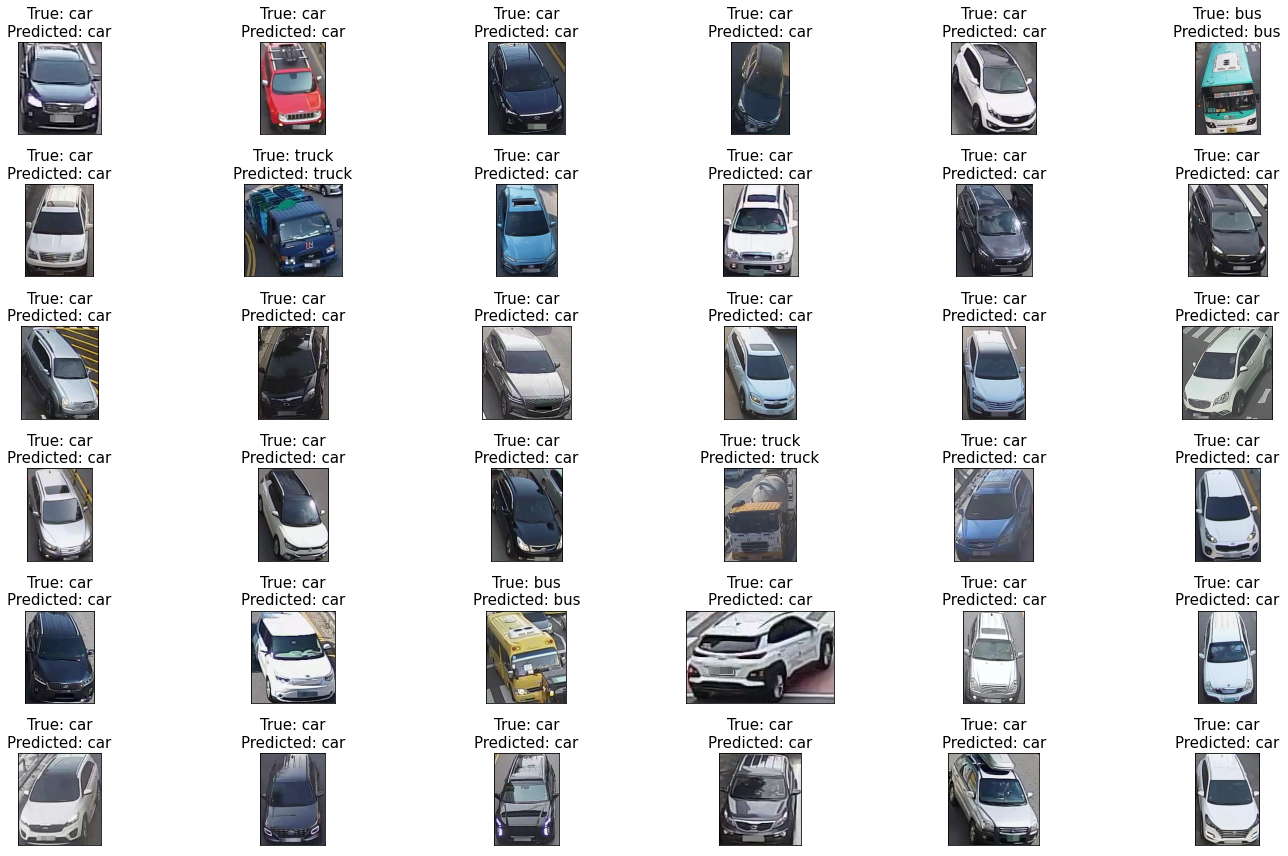

In [ ]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

### 좋은 효율을 내는 모델 성능확인 2 (ResNet152V2)
* 다음으로는 resnet모델을 학습했습니다. 5에포크로 학습을 진행했고 2에포크에서 정확도는 1을 로스는 0에 수렴했다.

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet152V2)
history = model.fit(train_images,validation_data=val_images,epochs=5)

Found 98980 validated image filenames belonging to 3 classes.
Found 10997 validated image filenames belonging to 3 classes.
Found 12220 validated image filenames belonging to 3 classes.
234561536/234545216 [==============================] - 5s 0us/step
Epoch 1/5
3094/3094 [==============================] - 478s 152ms/step - loss: 0.0130 - accuracy: 0.9956 - val_loss: 0.0065 - val_accuracy: 0.9980
Epoch 2/5
3094/3094 [==============================] - 470s 152ms/step - loss: 0.0051 - accuracy: 0.9984 - val_loss: 0.0096 - val_accuracy: 0.9977
Epoch 3/5
3094/3094 [==============================] - 468s 151ms/step - loss: 0.0039 - accuracy: 0.9986 - val_loss: 0.0057 - val_accuracy: 0.9980
Epoch 4/5
3094/3094 [==============================] - 465s 150ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0049 - val_accuracy: 0.9984
Epoch 5/5
3094/3094 [==============================] - 465s 150ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0066 - val_accuracy: 0.9984


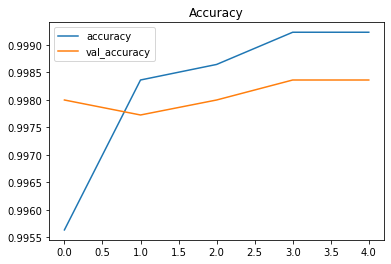

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

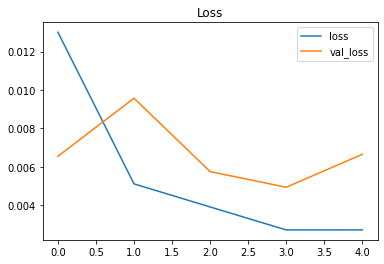

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

def printmd(string):
    # Print with Markdowns    moo
    display(Markdown(string))
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')

# Accuracy on the test set: 99.91%

In [ ]:
model.save("/content/drive/MyDrive/models/test_0705_resnet152v2.h5")

# ResNet152V2모델 예측

In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

         bus       1.00      1.00      1.00      1280
         car       1.00      1.00      1.00     10200
       truck       1.00      0.99      0.99       740

    accuracy                           1.00     12220
   macro avg       1.00      1.00      1.00     12220
weighted avg       1.00      1.00      1.00     12220



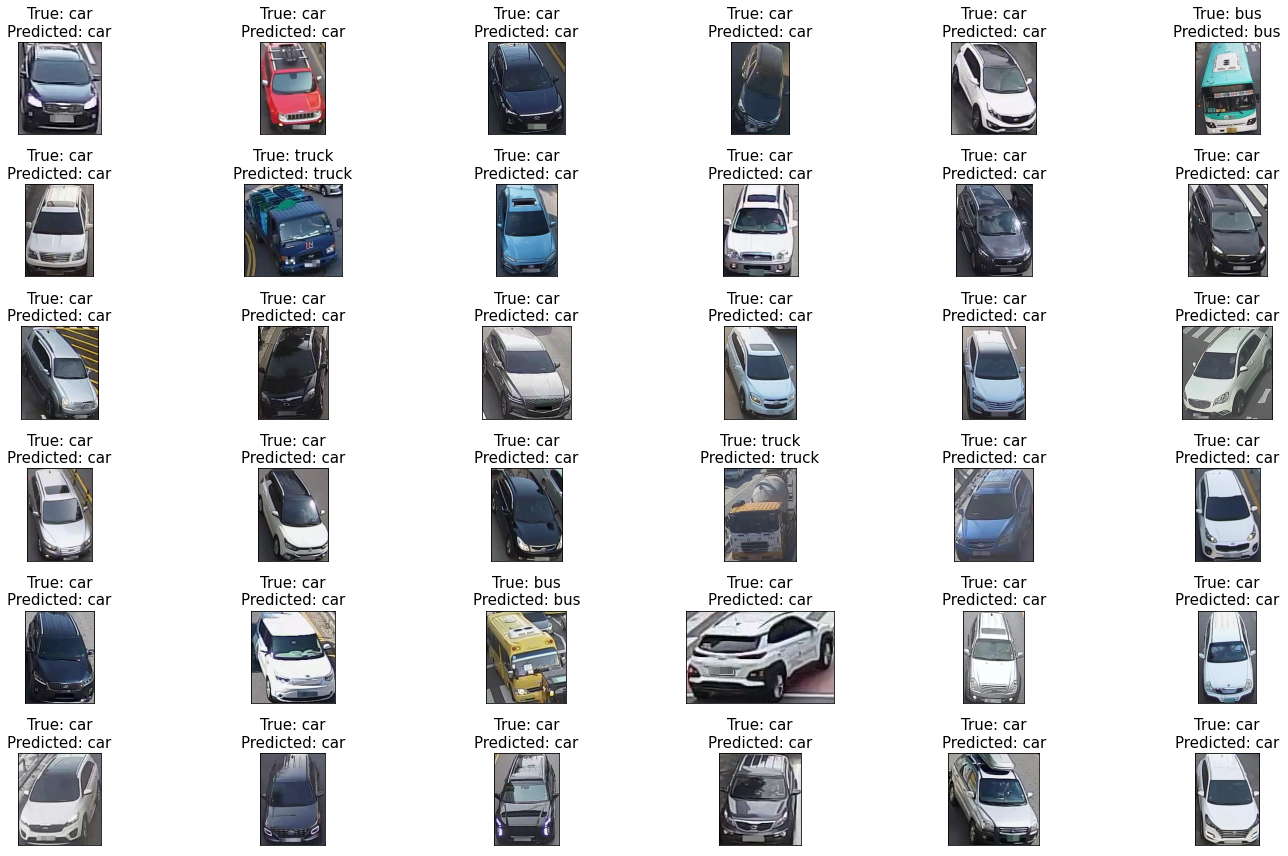

In [ ]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

## 라벨 데이터 저장

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import pickle

In [ ]:
y_data = df['Label']
y_data = y_data.apply(lambda ys: [y for y in ys.split(',')])

mlb = MultiLabelBinarizer()

mlb.fit(y_data)
print(mlb.classes_)
label_file = open("/content/drive/MyDrive/models/test_0705_vehicle_labelvehicle_label.pickle", "wb")
label_file.write(pickle.dumps(mlb))
label_file.close()

['bus' 'car' 'truck']
